In [1]:
import torchvision
import torchvision.transforms as transforms

In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))]
)

In [3]:
transform

Compose(
    ToTensor()
    Normalize(mean=(0.1307,), std=(0.3081,))
)

In [4]:
train_dataset = torchvision.datasets.MNIST(
    root="../data/mnist/", train=True, download=True, transform=transform
)

test_dataset = torchvision.datasets.MNIST(
    root="../data/mnist/", train=False, download=True, transform=transform
)

In [5]:
import torch

In [6]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=256, shuffle=False)

In [7]:
import torch.nn as nn

In [8]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10)
        self.dropout = nn.Dropout(0.25)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))  # 28x28 -> 14x14
        x = self.pool(torch.relu(self.conv2(x)))  # 14x14 -> 7x7
        x = x.view(-1, 64 * 7 * 7)
        x = self.dropout(x)
        x = self.fc1(x)
        x = torch.relu(x)
        x = self.fc2(x)
        return x

In [9]:
import torch.optim as optim

In [10]:
model = CNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [11]:
def train(model, train_loader, test_loader, optimizer, criterion, epochs=10):
    model.train()

    train_losses = []
    train_accuracies = []
    test_losses = []
    test_accuracies = []

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        for images, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        epoch_train_loss = running_loss / len(train_loader)
        epoch_train_acc = 100 * correct_train / total_train
        train_losses.append(epoch_train_loss)
        train_accuracies.append(epoch_train_acc)

        model.eval()
        test_loss = 0.0
        correct_test = 0
        total_test = 0

        with torch.no_grad():
            for images, labels in test_loader:
                outputs = model(images)
                loss = criterion(outputs, labels)
                test_loss += loss.item()

                _, predicted = torch.max(outputs.data, 1)
                total_test += labels.size(0)
                correct_test += (predicted == labels).sum().item()

        epoch_test_loss = test_loss / len(test_loader)
        epoch_test_acc = 100 * correct_test / total_test
        test_losses.append(epoch_test_loss)
        test_accuracies.append(epoch_test_acc)

        print(f"Epoch {epoch+1}/{epochs}")
        print(f"Train Loss: {epoch_train_loss:.4f} | Train Acc: {epoch_train_acc:.2f}%")
        print(f"Test Loss: {epoch_test_loss:.4f} | Test Acc: {epoch_test_acc:.2f}%\n")

    return train_losses, train_accuracies, test_losses, test_accuracies

In [12]:
epochs = 3

In [13]:
train_losses, train_acc, test_losses, test_acc = train(
    model, train_loader, test_loader, optimizer, criterion, epochs=epochs
)

Epoch 1/3
Train Loss: 0.1414 | Train Acc: 95.67%
Test Loss: 0.0574 | Test Acc: 98.19%

Epoch 2/3
Train Loss: 0.0508 | Train Acc: 98.42%
Test Loss: 0.0337 | Test Acc: 98.96%

Epoch 3/3
Train Loss: 0.0368 | Train Acc: 98.85%
Test Loss: 0.0265 | Test Acc: 99.04%



In [14]:
import matplotlib.pyplot as plt

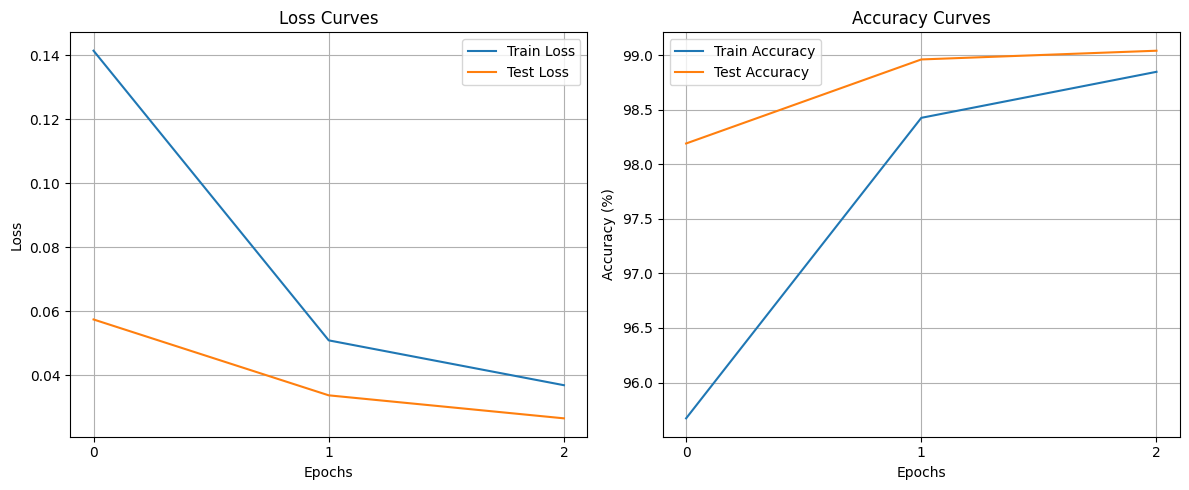

In [15]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.grid(True)
plt.plot(train_losses, label="Train Loss")
plt.plot(test_losses, label="Test Loss")
plt.title("Loss Curves")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.xticks(range(epochs))
plt.legend()

plt.subplot(1, 2, 2)
plt.grid(True)
plt.plot(train_acc, label="Train Accuracy")
plt.plot(test_acc, label="Test Accuracy")
plt.title("Accuracy Curves")
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.xticks(range(epochs))
plt.legend()

plt.tight_layout()
plt.savefig("../pics/3/losses.png")
plt.show()

In [16]:
import pandas as pd
from sklearn.metrics import classification_report

In [17]:
def predict(model, test_loader):
    model.eval()
    true_labels = []
    predicted_labels = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(next(model.parameters()).device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            true_labels.extend(labels.cpu().numpy())
            predicted_labels.extend(preds.cpu().numpy())

    results_df = pd.DataFrame({"True": true_labels, "Predicted": predicted_labels})

    return results_df

In [18]:
results = predict(model, test_loader)

In [19]:
print(
    classification_report(
        results["True"], results["Predicted"], target_names=[str(i) for i in range(10)]
    )
)

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       980
           1       0.99      1.00      0.99      1135
           2       0.99      0.99      0.99      1032
           3       0.99      0.99      0.99      1010
           4       0.99      0.99      0.99       982
           5       0.98      0.99      0.98       892
           6       0.99      0.99      0.99       958
           7       0.99      0.99      0.99      1028
           8       0.99      0.99      0.99       974
           9       0.99      0.99      0.99      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000



In [49]:
def visualize_filters(layer, layer_name):
    filters = layer.weight.detach().cpu().numpy()
    fig, axes = plt.subplots(4, 8, figsize=(12, 6))
    for i, ax in enumerate(axes.flat):
        if i < filters.shape[0]:
            ax.imshow(filters[i][0], cmap="viridis")
            ax.axis("off")
    plt.suptitle(layer_name)
    plt.savefig(f"../pics/3/{layer_name}.png")
    plt.show()

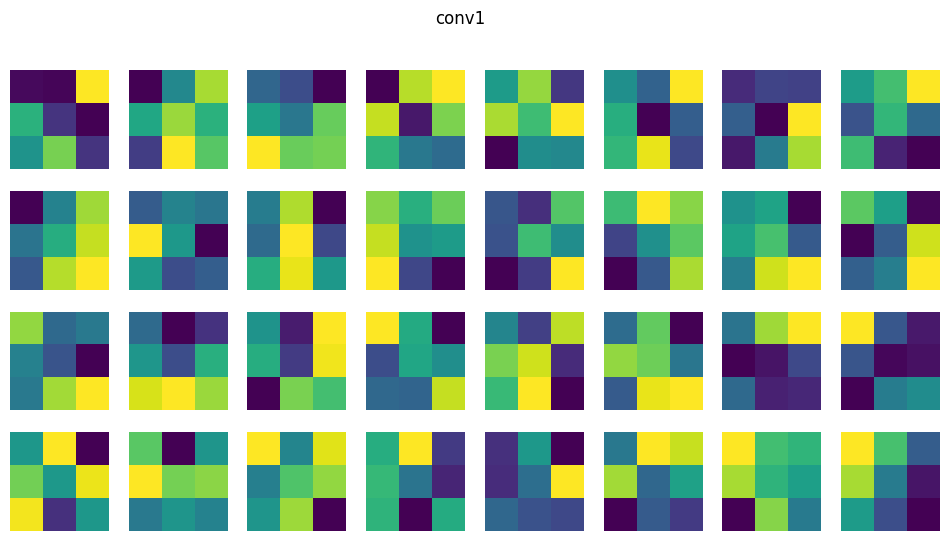

In [50]:
visualize_filters(model.conv1, "conv1")

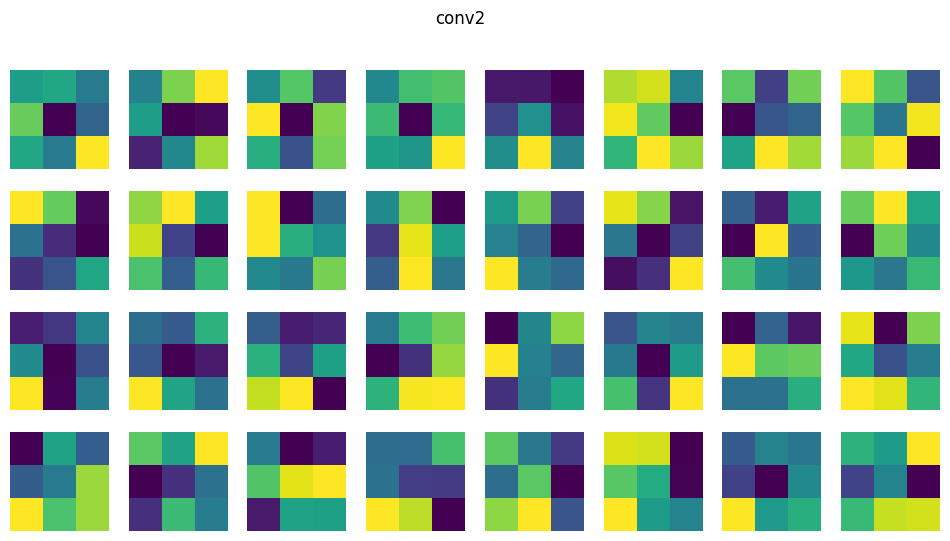

In [51]:
visualize_filters(model.conv2, "conv2")

In [59]:
def visualize_feature_maps(image, image_name):
    model.eval()
    activations = []

    def hook_fn(module, input, output):
        activations.append(output.detach())

    hook = model.conv1.register_forward_hook(hook_fn)
    with torch.no_grad():
        model(image.unsqueeze(0))
    hook.remove()

    act = activations[0][0]
    fig, axes = plt.subplots(4, 8, figsize=(12, 6))
    for i, ax in enumerate(axes.flat):
        if i < act.size(0):
            ax.imshow(act[i].cpu().numpy(), cmap="viridis")
            ax.axis("off")
    plt.suptitle(image_name)
    plt.savefig(f"../pics/3/{image_name}.png")
    plt.show()

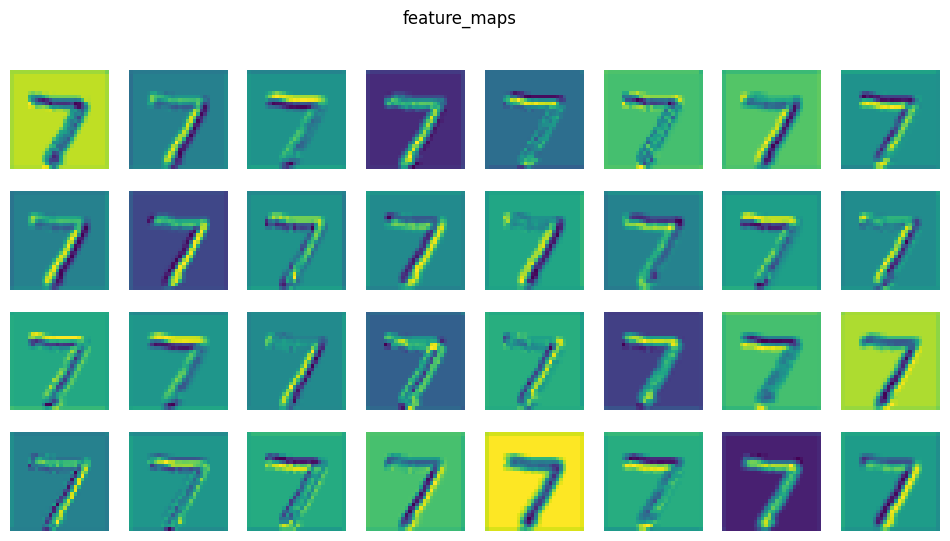

In [60]:
sample_image, _ = test_dataset[0]
visualize_feature_maps(sample_image, "feature_maps")